---
title: Lecture 4
subtitle: Transforms
date: 2024-09-11
downloads:
  - file: 04_lecture.ipynb
    title: 04_lecture.ipynb
  - file: ../assets/04_lecture.pdf
    title: 04_lecture.pdf
---

In [1]:
import warnings
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.fftpack import dct, idct

# Suppress all warnings
warnings.filterwarnings("ignore")

Image transforms are used to isolate patterns of interest, represent data in a more compact form, and are reversible.

The learning objectives are:
- DFT for images
- DCT
- Haramord-Walsh transform
- Haar transform

## DFT for images

### 1D Case

The [Fourier transform](wiki:Fourier_transform)[^1] is an integral transform that takes a function as input and outputs another function that describes the extent to which various frequencies are present in the original function. It is defined in [Equation (%s)](#equ-FT) The output of the transform is a complex-valued function of frequency.

:::{prf:definition} Fourier Transform
:nonumber: True
$$
\label{equ-FT}
\hat{f}(\zeta) = \int^{\infty}_{-\infty} f(x)e^{-i2\pi\zeta x} dx
$$

where,

- $\hat{f}(\zeta)$ is the frequency-domain representation of the function $f(x)$
- $\zeta$ is the frequency variable
- $f(x)$ is the original function in the time or spatial domain
- $x$ is the time or spatial variable 
:::

The [IFT](wiki:Fourier_inversion_theorem) is used to transform data from the frequency domain back to the time or spatial domain, and is defined in [Equation (%s)](#equ-IFT).

:::{prf:definition} IFT
:nonumber: True
$$
\label{equ-IFT}
f(x) = \int_{-\infty}^{\infty} \hat{f}(\zeta) e^{i 2\pi \zeta x} \, d\zeta
$$
:::

The [DFT](wiki:Discrete_Fourier_transform) is the Fourier transform applied to discrete data. It operates on a finite sequence of equally spaced samples, created for example by [np.linspace](#card-linspace), from a signal and is defined in [Equation (%s)](#equ-DFT).

:::{prf:definition} DFT
:nonumber: True
$$
\label{equ-DFT}
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-i \frac{2\pi}{N} k n}
$$

where,

- $X[k]$ is the k-th frequency component of the input signal $x[n]$
- $k$ is the frequency index
- $x[n]$ is the signal input in the time or spatial domain
- $n$ is the sample index
:::

The [FFT](wiki:Fast_Fourier_transform) is an efficient algorithm to compute the DFT. It reduces the computational complexity of the DFT from $O(N^{2})$ to $O(N\log{N})$.

:::{note}
When using [np.fft.fft](#card-fft) the function performs the DFT via the FFT algorithm.
:::

The IDFT is used when working with discrete data to convert the data from the frequency domain back to the time or spatial domain and is defined in [Equation (%s)](#equ-IDFT).

:::{prf:definition} IDFT
:nonumber: True
$$
\label{equ-IDFT}
f[n] = \frac{1}{N} \sum_{k=0}^{N-1} \hat{f}[k] e^{i \frac{2 \pi}{N} k n}
$$
:::

[^1]: The accompanying video does a great job describing the Fourier transform.
    :::{iframe} https://www.youtube.com/embed/spUNpyF58BY?si=siTxY9oE7mT2z1oX
    :::

### Example

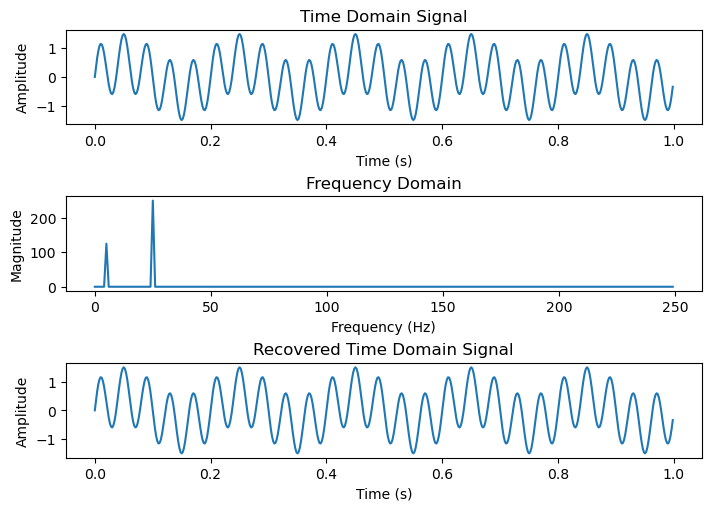

In [2]:
# define the time domain signal
sampling_rate = 500 # samples per second
T = 1.0 / sampling_rate # seconds per sample (sampling interval)
duration = 1.0
N = int(duration * sampling_rate) # samples
x = np.linspace(0.0, duration, N, endpoint=False) # False to account for 0-index

# create a signal composed of two difference sine waves
freq1 = 5
freq2 = 25
signal = 0.5 * np.sin(2.0 * np.pi * freq1 * x) + 1 * np.sin(2.0 * np.pi * freq2 * x)

# compute the DFT using FFT
fft_values = np.fft.fft(signal)

# real-valued signals have symmetric FTs, so just take the positive half of the spectrum
fft_mag = np.abs(fft_values)[:N // 2]
freqs = np.fft.fftfreq(N, T)[:N // 2]

# compute the Inverse Fourier Transform using IFFT
recovered_signal = np.fft.ifft(fft_values)

# plot the results
fig, axs = plt.subplots(3, 1, figsize=(7,5), layout='constrained')
axs[0].plot(x, signal); axs[0].set_title('Time Domain Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[1].plot(freqs, fft_mag)
axs[1].set_title('Frequency Domain')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')
axs[2].plot(x, recovered_signal); axs[2].set_title('Recovered Time Domain Signal')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
plt.show()

__Takeaways__

The time domain signal looks complex because of the superposition of two sine waves with different frequencies. In the frequency domain it is clear that the signal is composed of two frequencies (e.g., 5 Hz and 25 Hz). Lastly, the magnitude of the peaks in the frequency domain gives information on the relative strength of each frequency in the original signal.

### 2D Case

The Fourier transform for 2D is an integral transform that extends the 1D case to two dimensions. It takes a 2D function as the input and outputs another function that describes the extent to which various frequencies are present in the original 2D function.

The result is a complex-valued function representing the frequency domain in both dimensions and is defined in [Equation (%s)](#equ-2FT).

:::{prf:definition} 2D Fourier Transform
:nonumber: True
$$
\label{equ-2FT}
\hat{f}(u, v) = \int^{\infty}_{-\infty}\int^{\infty}_{-\infty}f(x,y)e^{-i2\pi (ux+uy)}\,dx\,dy
$$

where,

- $\hat{f}(u,v)$ is the frequency domain representation of the 2D function $f(x,y)$
- $u$ is the frequency variable in the horizontal direction
- $v$ is the frequency variable in the vertical direction
- $f(x,y)$ is the original function in the time or spatial domain
- $x$ and $y$ are the spatial variables

The 2D IFT is used to transform the data from the frequency domain back to the spatial domain and is defined in [Equation(%s)](#equ-2IFT).

:::{prf:definition} 2D IFT
:nonumber: True
$$
\label{equ-2IFT}
f(x,y) = \int^{\infty}_{-\infty}\int^{\infty}_{-\infty}\hat{f}(u,v)e^{i2\pi (ux + vy)} \, du \, dv
$$

where,

- $f(x,y)$ is the reconstructed function in the spatial domain
- $\hat{f}(u,v)$ is the frequency domain representation of the original function
- $u$ and $v$ are the frequency variables in the horizontal and vertical directions
- $x$ and $y$ are the spatial variables

The 2D DFT operates on a finite 2D grid of equally spaced samples and is defined in [Equation (%s)](#equ-2DFT).

:::{prf:definition} 2D DFT
:nonumber: True
$$
\label{equ-2DFT}
X[u, v] = \frac{1}{\sqrt{NM}}\sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot e^{-i 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

where,

- $X[u,v]$ is the frequency component of the 2D signal $f(x,y)$
- $u$ and $v$ are the frequency indices in the horizontal and vertical directions
- $f(x,y)$ is the signal input in the 2D time or spatial domain
- $x$ and $y$ are the sample indices in the horizontal and vertical directions
- $M$ and $N$ are the dimensions of the 2D array (e.g., the number of rows and columns)

The 2D DFT can be represented in matrix form, which is commonly used in image processing. The 2D DFT is essentially two 1D DTS: one applied along the rows, and then one applied along the columns and is defined in [Equation (%s)](#equ-2DFTMat).

:::{prf:definition} 2D DFT Matrix Form
:nonumber: True
$$
\label{equ-2DFTMat}
X = F_M \cdot f \cdot F^{T}_N
$$

where,

- $X$ is the matrix representing the 2D DFT for the image
- $f$ is the original 2D signal (e.g., the image)
- $F_M$ is the DFT matrix for the rows
- $F^{T}_M$ is the transpose of the DFT matrix for the columns

$F_M$ and $F_N$ can be found from the following:

$$
\begin{equation*}
F = \frac{1}{\sqrt{n}} \begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & e^{-i 2 \pi \frac{1}{n}} & e^{-i 2 \pi \frac{2}{n}} & \cdots & e^{-i 2 \pi \frac{n-1}{n}} \\
1 & e^{-i 2 \pi \frac{2}{n}} & e^{-i 2 \pi \frac{4}{n}} & \cdots & e^{-i 2 \pi \frac{2(n-1)}{n}} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & e^{-i 2 \pi \frac{n-1}{n}} & e^{-i 2 \pi \frac{2(n-1)}{n}} & \cdots & e^{-i 2 \pi \frac{(n-1)(n-1)}{n}} \\
\end{bmatrix}
\end{equation*}
$$

The 2D IDFT is used to convert an image from the frequency domain back to the spatial domain to reconstruct the original signal and is defined in [Equation (%s)](#equ-2DIDFT).

:::{prf:definition} 2D IDFT
:nonumber: True
$$
\label{equ-2DIDFT}
f(x, y) = \frac{1}{\sqrt{NM}} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} X(u, v) \cdot e^{i 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

where,

- $f(x,y)$ is the reconstructed spatial signal
- $X(u,v)$ is the frequency domain representation of the signal
- $M$ and $N$ are the dimensions of the signal
- $u$ and $v$ are the frequency indices
- $x$ and $y$ are the spatial indices
:::

The 2D IDFT can be expressed in matrix form and is defined in [Equation (%s)](#equ-2DIDFTMat).

:::{prf:definition} 2D IDFT Matrix Form
:nonumber: True
$$
\label{equ-2DIDFTMat}
f = \frac{1}{\sqrt{NM}} F_M^H \cdot X \cdot F_N^H
$$

where,

- $f$ is the image in the spatial domain
- $X$ is the image in the frequency domain
- $F^{H}_M$ is the Hermitian transpose (complex conjugate transpose) of the DFT matrix for the rows
- $F^{H}_N$ is the Hermitian transpose of the DFT matrix for the columns
:::

#### Example

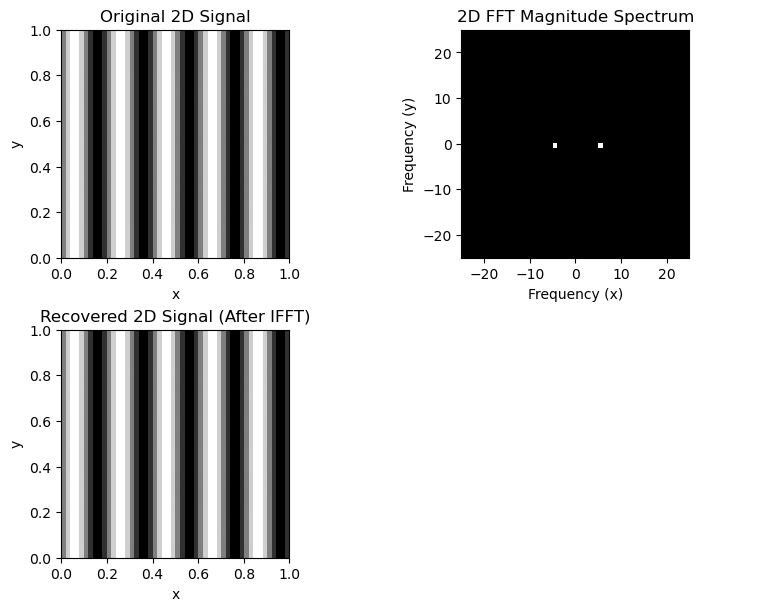

In [60]:
# Define the 2D signal dimensions
rows, cols = 50, 50  # 2D grid size (like an image)
x = np.linspace(0, 1, cols, endpoint=False)  # Time/spatial samples for the columns
y = np.linspace(0, 1, rows, endpoint=False)  # Time/spatial samples for the rows
X, Y = np.meshgrid(x, y)  # Create a 2D mesh grid

# Create a 2D signal composed of two different sine waves
freq1 = 5  # Frequency in the x direction
freq2 = 25  # Frequency in the y direction
signal_2d = 0.5 * np.sin(2.0 * np.pi * freq1 * X) + 1.0 * np.sin(2.0 * np.pi * freq2 * Y)

# Compute the 2D DFT using FFT
fft_values_2d = np.fft.fft2(signal_2d)

# Shift the zero-frequency component to the center for visualization purposes
fft_shifted = np.fft.fftshift(fft_values_2d)

# Compute the magnitude spectrum of the 2D FFT
fft_magnitude = np.abs(fft_shifted)

# Compute the inverse 2D FFT to recover the original signal
recovered_signal_2d = np.fft.ifft2(fft_values_2d).real  # Take only the real part

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(8,6), layout='constrained')

# Plot the original 2D signal
axs[0,0].imshow(signal_2d, cmap='gray', extent=[0, 1, 0, 1])
axs[0,0].set_title('Original 2D Signal')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')

# Plot the magnitude spectrum of the 2D FFT (Frequency Domain)
axs[0,1].imshow(np.log(fft_magnitude + 1), cmap='gray', extent=[-cols/2, cols/2, -rows/2, rows/2])
axs[0,1].set_title('2D FFT Magnitude Spectrum')
axs[0,1].set_xlabel('Frequency (x)')
axs[0,1].set_ylabel('Frequency (y)')

# Plot the recovered 2D signal after Inverse FFT
axs[1,0].imshow(recovered_signal_2d, cmap='gray', extent=[0, 1, 0, 1])
axs[1,0].set_title('Recovered 2D Signal (After IFFT)')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')

axs[1,1].axis('off')

plt.show()

__Takeaways__



## DCT

The DCT is a mathematical transformation used to convert a signal or image from the spatial domain to the frequency domain using only cosine functions. It is similar to the DFT but uses only real numbers (cosines) rather than complex exponentials (sines and cosines).

There are several types of DCT, but the most common one is DCT Type-II which is show in [Equation (%s)](#equ-DCT).

:::{prf:definition} 2D DCT
:nonumber: True
$$
\label{equ-DCT}
X[k_1, k_2] = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot \cos\left( \frac{\pi}{M} \left( x + \frac{1}{2} \right) k_1 \right) \cdot \cos\left( \frac{\pi}{N} \left( y + \frac{1}{2} \right) k_2 \right)
$$

where,

- $X[k_1, k_2]$ is the frequency-domain representation of the 2D signal.
- $f(x, y)$ is the original signal in the spatial domain.
- $M$ and $N$ are the dimensions of the 2D signal.
- $k_1$ and $k_2$ are the frequency indices for the x- and y-directions.
:::

The IDCT is a mathematical transformation used to convert a signal or image from the frequency domain back to the spatial domain. It is used to reconstruct the original signal after applying the DCT, and it works by summing over cosine functions weighted by their corresponding DCT coefficients.

The most common form used is the IDCT Type-II, which is shown in [Equation (%s)](#equ-IDCT).

:::{prf:definition} 2D IDCT
:nonumber: True
$$
\label{equ-IDCT}
f(x, y) = \frac{4}{MN} \sum_{k_1=0}^{M-1} \sum_{k_2=0}^{N-1} \alpha(k_1) \alpha(k_2) \cdot X[k_1, k_2] \cdot \cos\left( \frac{\pi}{M} \left( x + \frac{1}{2} \right) k_1 \right) \cdot \cos\left( \frac{\pi}{N} \left( y + \frac{1}{2} \right) k_2 \right)
$$

where,

- $f(x, y)$ is the reconstructed signal in the spatial domain.
- $X[k_1, k_2]$ is the frequency-domain representation of the 2D signal.
- $M$ and $N$ are the dimensions of the 2D signal.
- $x$ and $y$ are the spatial indices for the rows and columns.
- $k_1$ and $k_2$ are the frequency indices for the x- and y-directions.
- $\alpha(k)$ is a normalization factor that is equal to:

  \begin{equation*}
  \alpha(k) = \begin{cases}
  \frac{1}{\sqrt{2}} & \text{if } k = 0 \\
  1 & \text{otherwise}
  \end{cases}
  \end{equation*}

:::

The **2D IDCT** is used to reconstruct the original image or signal from its frequency components. The normalization factor $\alpha(k)$ is important because it ensures that the DC component (the zero frequency) is scaled appropriately during the reconstruction.

### Example

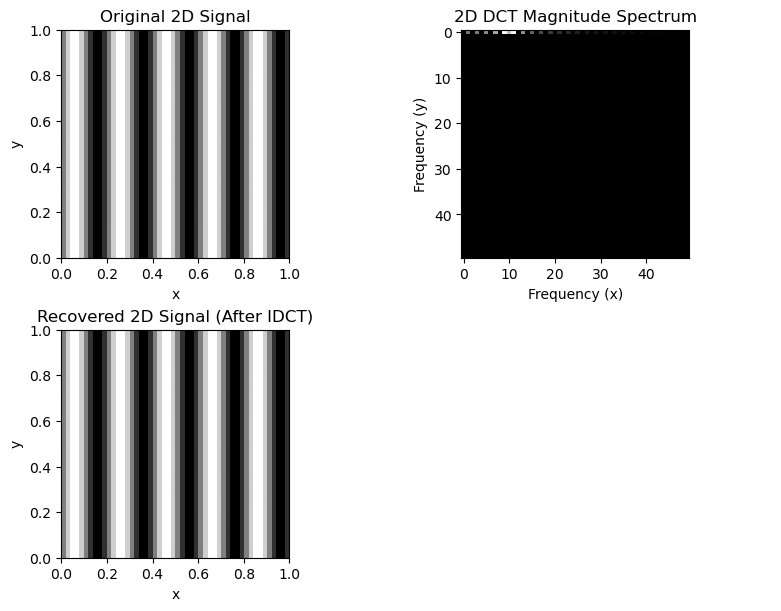

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Define the 2D signal dimensions
rows, cols = 50, 50  # 2D grid size (like an image)
x = np.linspace(0, 1, cols, endpoint=False)  # Time/spatial samples for the columns
y = np.linspace(0, 1, rows, endpoint=False)  # Time/spatial samples for the rows
X, Y = np.meshgrid(x, y)  # Create a 2D mesh grid

# Create a 2D signal composed of two different sine waves
freq1 = 5  # Frequency in the x direction
freq2 = 25  # Frequency in the y direction
signal_2d = 0.5 * np.sin(2.0 * np.pi * freq1 * X) + 1.0 * np.sin(2.0 * np.pi * freq2 * Y)

# Compute the 2D DCT using scipy's dct function
dct_values_2d = dct(dct(signal_2d.T, norm='ortho').T, norm='ortho')

# Compute the inverse 2D DCT to recover the original signal
recovered_signal_2d = idct(idct(dct_values_2d.T, norm='ortho').T, norm='ortho')

# Compute the magnitude spectrum of the 2D DCT
dct_magnitude = np.abs(dct_values_2d)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(8,6), layout='constrained')

# Plot the original 2D signal
axs[0,0].imshow(signal_2d, cmap='gray', extent=[0, 1, 0, 1])
axs[0,0].set_title('Original 2D Signal')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')

# Plot the magnitude spectrum of the 2D DCT (Frequency Domain)
axs[0,1].imshow(np.log(dct_magnitude + 1), cmap='gray', extent=[-cols/2, cols/2, -rows/2, rows/2])
axs[0,1].set_title('2D DCT Magnitude Spectrum')
axs[0,1].set_xlabel('Frequency (x)')
axs[0,1].set_ylabel('Frequency (y)')

# Plot the recovered 2D signal after Inverse DCT
axs[1,0].imshow(recovered_signal_2d, cmap='gray', extent=[0, 1, 0, 1])
axs[1,0].set_title('Recovered 2D Signal (After IDCT)')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')

# Turn off the fourth subplot
axs[1,1].axis('off')

plt.show()

__Takeaways__

The original 2D signal, composed of sine waves in the x- and y-directions, is correctly reconstructed by the IDCT, indicating that the DCT and IDCT are functioning as expected.

## Hadamard-Walsh Transform

The HWT is similar to the DFT and DCT; however, instead of using sine and cosine functions it uses sequences of orthogonal square waves.

### Hadamard Transform

The Hadamard transform is a linear transformation, defined in [Equation (%s)](#equ-HT) based on the Hadamard matrix, which is a matrix composed of $+1$ and $-1$ with the following properties:

- The rows and columns are orthogonal to each other
- The matrix is recursively built using smaller matrices through the Kronecker product

:::{important}
The smallest Hadamard matrix is $H_2$:

\begin{equation*}
H_2 = 
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
\end{equation*}
:::

Larger Hadamard matrices, like $H_4$ are constructed as:

\begin{equation*}
H_4 = H_2 \otimes H_2 = 
\begin{bmatrix}
  h_{11}H_2 & h_{12}H_2 \\
  h_{21}H_2 & h_{22}H_2
\end{bmatrix} =
\begin{bmatrix}
  1 & 1 & 1 & 1 \\
  1 & -1 & 1 & -1 \\
  1 & 1 & -1 & -1 \\
  1 & -1 & -1 & 1
\end{bmatrix}
\end{equation*}

:::{prf:definition} Hadamard Transform
:nonumber: True
$$
\label{equ-HT}
F = \frac{1}{N^2}H_{n \times n} \cdot x \cdot H_{n \times n}^{T}
$$

where,

- $F$ is the transformed signal (in the Hadamard domain)
- $x$ is the input signal (or input image for the 2D case)
- $H_{n /times n}$ is the Hadamard matrix of size $n \times n$
- $\frac{1}{N^2}$ is a scaling factor based on the size of the matrix
:::

Hadamard matrices can be constructed using the [hadamard](#card-hadamard) function from `scipy.linalg`.

In [12]:
from scipy.linalg import hadamard

# generate a Hadamard matrix of size 8 x 8
n = 8 # must be a power of 2
H = hadamard(n)

# print the matrix
print(H)

[[ 1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1 -1 -1  1 -1  1  1 -1]]


The 2D Hadamard transform, defined in [Equation (%s)](#equ-2DHT), is an extension of the Hadamard transform.

:::{prf:definition} 2D Hadamard Transform
:nonumber: True
$$
\label{equ-2DHT}
F = \frac{1}{N \times M}H_{n \times n} \cdot x \cdot H_{m \times m}^{T}
$$

where,

- $N \times M$ is the size of the 2D input image
- $H_{n /times n}$ and $H_{m \times m}$ are the Hadamard matrices applied to the rows and columns of the input, respectively
- The Hadamard transform is applied to the rows first (with $H_{n \times n}$) and then to the columns (with $H_{m \times m}^{T}$)
:::

#### Example

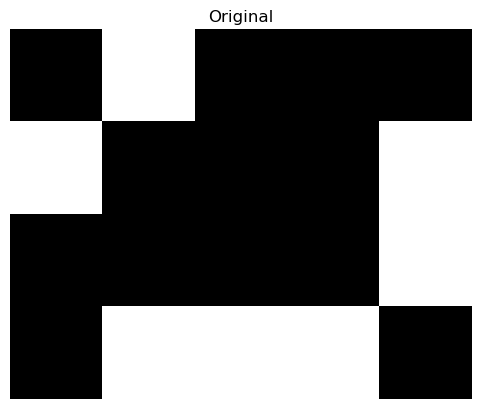

In [45]:
from scipy.linalg import hadamard

# set the seed for reproducible results
np.random.seed(42)

# Create a 4x5 matrix of random 1's and 0's
img = np.random.randint(0, 2, (4, 5))  # Randomly select between 0 and 1

# show the original image
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original')
ax.axis('off')
plt.show()

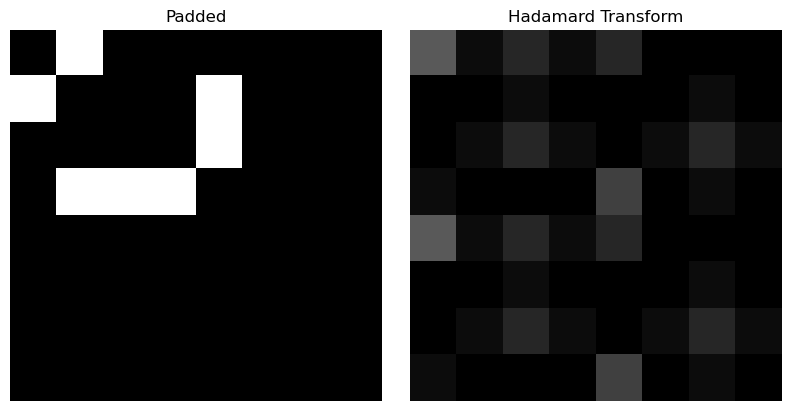

In [46]:
from scipy.linalg import hadamard

# set the seed for reproducible results
np.random.seed(42)

# Create a 4x5 matrix of random 1's and 0's
img = np.random.randint(0, 2, (4, 5))  # Randomly select between 0 and 1

# get the size of the image
N, M = img.shape

# image dimensions must have dimensions that are a power of 2
pad_rows = 8 - N
pad_cols = 8 - M

# apply the padding
img_padded = np.pad(img, ((0, pad_rows), (0, pad_cols)), mode='constant')

# get the padding shape (i.e., 8 x 8)
N_pad, M_pad = img_padded.shape

# create the Hadamard matrices
H_n = hadamard(N_pad)
H_m = hadamard(M_pad)

# apply to the rows of the image
H_rows = np.dot(H_n, img_padded)

# apply to the columns of the image
H_cols = np.dot(H_rows, H_m.T)

# normalize to get the result
HT = H_cols / (N * M)

# show the results
fig, axs = plt.subplots(1, 2, figsize=(8,4), layout='constrained')
axs[0].imshow(img_padded, cmap='gray', vmin=0, vmax=1, aspect=1)
axs[0].set_title('Padded')
axs[0].axis('off')
axs[1].imshow(HT, cmap='gray', vmin=0, vmax=1, aspect=1)
axs[1].set_title('Hadamard Transform')
axs[1].axis('off')
plt.show()

The original image can be reconstructed using the Inverse Hadamard Transform, defined in [Equation (%s)](#equ-2DIHT).

:::{prf:definition} Inverse 2D Hadamard Transform
:nonumber: True
$$
\label{equ-2DIHT}
x = \frac{1}{N \times M} H_{n \times n}^{T} \cdot F \cdot H_{m \times m}^{T}
$$

where,

- $x$ is the original 2D signal (or input image)
- $F$ is the transformed 2D signal (in the Hadamard domain)
- $H_{n \times n}$ is the Hadamard matrix applied to the rows (size $n \times n$)
- $H_{m \times m}$ is the Hadamard matrix applied to the columns (size $m \times m$)
- $\frac{1}{N \times M}$ is a scaling factor based on the size of the original 2D image ($N \times M$)
:::

#### Example

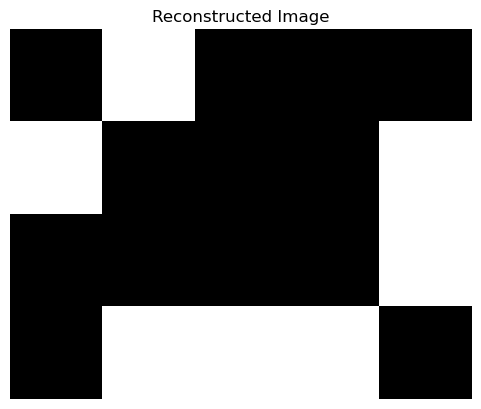

In [48]:
# reconstruct the original image, apply the Hadamard transform again
H_inv_rows = np.dot(H_n, HT)
H_inv_cols = np.dot(H_inv_rows, H_m.T)

# Normalize again to reconstruct the original image
reconstructed_img = H_inv_cols * (N * M)

# Remove the padding to get back the original image dimensions
reconstructed_img_cropped = reconstructed_img[:N, :M]

# Plot the results
fig, ax = plt.subplots()
ax.imshow(reconstructed_img_cropped, cmap='gray', vmin=0, vmax=1, aspect=1)
ax.set_title('Reconstructed Image')
ax.axis('off')
plt.show()

### Walsh-Hadamard Transform

The Walsh-Hadamard Transform, defined in [Equation (%s)](#equ-2DWHT), is based on Walsh functions which are orthogonal functions that take values 1 or -1. The Walsh-Hadamard Transform decomposes a signal into Walsh functions.

The Walsh-Hadamard Transform is similar to the Hadamard Transform, but the ordering of the rows is different.

:::{prf:definition} Walsh-Hadamard Transform
:nonumber:True
$$
\label{equ-2DWHT}
F = \frac{1}{N \times M}W_{n \times n} \cdot x \cdot W_{m \times m}^{T}
$$

where,

- $N \times M$ is the size of the 2D input image
- $W_{n /times n}$ and $W_{m \times m}$ are the Walsh matrices applied to the rows and columns of the input, respectively
- The Walsh-Hadamard transform is applied to the rows first (with $W_{n \times n}$) and then to the columns (with $W_{m \times m}^{T}$)

The Walsh matrix can be derived from the Hadamard matrix by reordering its rows according to sequency (sign changes). The smallest Walsh matrix, \( W_2 \), is the same as the Hadamard matrix \( H_2 \), but larger Walsh matrices are reordered versions of their corresponding Hadamard matrices.

The **Hadamard matrix** $H_4$ is given by:

$$
H_4 = \frac{1}{\sqrt{4}} \begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1
\end{bmatrix}
$$

To create the Walsh matrix $W_4$, we reorder the rows based on their **sequency** (the number of sign changes in each row):

$$
W_4 = \frac{1}{\sqrt{4}} \begin{bmatrix}
1 & 1 & 1 & 1 \quad \text{(sequency 0)} \\
1 & 1 & -1 & -1 \quad \text{(sequency 1)} \\
1 & -1 & 1 & -1 \quad \text{(sequency 2)} \\
1 & -1 & -1 & 1 \quad \text{(sequency 3)}
\end{bmatrix}
$$


In [54]:
from scipy.linalg import hadamard

def count_sign_changes(row):
    """Counts the number of sign changes in a row."""
    return np.sum(np.diff(row) != 0)

# Generate a Hadamard matrix of size 8 x 8
n = 8
H = hadamard(n)

# Count the number of sign changes in each row of the Hadamard matrix
sign_changes = np.array([count_sign_changes(row) for row in H])

# Generate the sequency order by sorting rows based on sign changes
sequency_order = np.argsort(sign_changes)

# Reorder the rows of the Hadamard matrix to get the Walsh matrix
W = H[sequency_order, :]

# Print the Walsh matrix
print(W)

[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1 -1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]]


## Haar Transform